<a href="https://colab.research.google.com/github/sushmit86/Statiistical_rethinking_jax/blob/main/sushmit_04_geocentric_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install packages that are not installed in colab
try:
  import google.colab
  !pip install watermark
  !pip install jaxopt
except:
  pass

In [2]:
%load_ext watermark

In [3]:
#@title import library
import numpy as np
import pandas as pd
import jax
import jax.numpy as jnp
from tensorflow_probability.substrates import jax as tfp_jax
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
import plotly.express as px
import plotly.subplots  as sp
import plotly.graph_objects as go
from IPython.display import display
import arviz
import plotly.figure_factory as ff
import plotly.graph_objects as go
import jaxopt
from jaxopt import ScipyMinimize
from collections import OrderedDict
key = jax.random.PRNGKey(42)

def marginal_test_results(model, results, nll,credib_interval = 0.89, num_of_samples = 10000):
  '''
  model: tfp model like
  results: results from optimizing
  nll: negative log likelihood function
  credib_interval: the interval we are interested in
  num_of_samples: number of samples we want to get from the posterior distribution
  '''
  key = jax.random.PRNGKey(42)
  inv_hessian_matrix = jnp.linalg.inv(jax.hessian(nll)(results.params))
  mean_list = results.params
  sd_list = jnp.diagonal(inv_hessian_matrix)**(1/2)
  low_credib_interval = (1 - credib_interval)/2
  high_credib_interval = 1 - low_credib_interval
  parameter_list = []
  normal_dist = tfp_jax.distributions.Normal(loc=mean_list,scale =  sd_list)
  for _parameter in model.parameters['model']:
    if isinstance(model.parameters['model'][_parameter],tfp_jax.distributions.Distribution):
      try:
        _shape = model.parameters['model'][_parameter].event_shape[0]
        parameter_list.extend([_parameter + '_' +str(i) for i in range(0, _shape)])
      except:
        parameter_list.append(_parameter)

  df_result = pd.DataFrame({'mean': mean_list,
                           'sd':sd_list,
                            'low': normal_dist.quantile(low_credib_interval),
                            'high':tfp_jax.distributions.Normal(loc=mean_list,scale =  sd_list).quantile(high_credib_interval) },
                           index = parameter_list)
  post_dist = tfp_jax.distributions.MultivariateNormalFullCovariance(
    loc=results.params,covariance_matrix=inv_hessian_matrix )
  post_samples = post_dist.sample( sample_shape=num_of_samples,seed=key)
  df_post_samples = pd.DataFrame(post_samples,columns = parameter_list)
  return df_result,inv_hessian_matrix,df_post_samples
# setting the decimal precision

pd.set_option("display.precision", 3)

In [4]:
#@title 4.1
simulations = jax.random.choice(key = key, a= jnp.array([-1,1]),shape = (16,10000))

fig = px.histogram(simulations.sum(axis=0),histnorm = 'probability')
fig.show()


In [5]:
#@title 4.2 - 4.5
random_samples = 1 + tfp_jax.distributions.Uniform(low=0,high = 0.1).sample((12,10000),seed = key)

fig = px.histogram(random_samples.prod(axis=0),histnorm = 'probability',width=800, height=400)
fig.show()

random_samples = 1 + tfp_jax.distributions.Uniform(low=0,high = 0.5).sample((12,10000),seed = key)

fig = px.histogram(random_samples.prod(axis=0),histnorm = 'probability',width=800, height=400)
fig.show()
random_samples = 1 + tfp_jax.distributions.Uniform(low=0,high = 0.5).sample((12,10000),seed = key)
fig = px.histogram(jnp.log(random_samples.prod(axis=0)),histnorm = 'probability',width=800, height=400)
fig.show()

In [6]:
#@title 4.6
w = 6
n = 9
p_grid = jnp.linspace(0,1,100)
prior = tfp_jax.distributions.Uniform().prob(p_grid)
likelihood = tfp_jax.distributions.Binomial(total_count=n,probs=p_grid).prob(w)
posterior = prior*likelihood
posterior = posterior/posterior.sum()
fig = px.line(x=p_grid,y=posterior,width=800, height=400)
fig.show()


In [7]:
#@title 4.7 - 4.11
d = pd.read_csv('https://raw.githubusercontent.com/sushmit86/Statiistical_rethinking_jax/main/Howell1.csv',sep= ';')
d.info()
display(d.head())
display(d.describe())
display(d.height)
d2 = d[d.age >= 18].copy()
## should have 352 rows
d2.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 544 entries, 0 to 543
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   height  544 non-null    float64
 1   weight  544 non-null    float64
 2   age     544 non-null    float64
 3   male    544 non-null    int64  
dtypes: float64(3), int64(1)
memory usage: 17.1 KB


,height,weight,age,male
0,151.765,47.826,63.0,1
1,139.700,36.486,63.0,0
2,136.525,31.865,65.0,0
3,156.845,53.042,41.0,1
4,145.415,41.277,51.0,0


,height,weight,age,male
count,544.000,544.000,544.000,544.000
mean,138.264,35.611,29.344,0.472
std,27.602,14.719,20.747,0.500
min,53.975,4.252,0.000,0.000
25%,125.095,22.008,12.000,0.000
50%,148.590,40.058,27.000,0.000
75%,157.480,47.209,43.000,1.000
max,179.070,62.993,88.000,1.000


0      151.765
1      139.700
2      136.525
3      156.845
4      145.415
        ...   
539    145.415
540    162.560
541    156.210
542     71.120
543    158.750
Name: height, Length: 544, dtype: float64

(352, 4)

In [8]:
#@title 4.12 -4.15
curve1=tfp_jax.distributions.Normal(loc=178,scale=20).prob(jnp.linspace(100,250))
fig = px.line(x=jnp.linspace(100,250),y=curve1,width=800, height=400)
fig.show()
curve2=tfp_jax.distributions.Uniform(0,50).prob(jnp.linspace(-10,60))
fig = px.line(x=jnp.linspace(-10,60),y=curve2,width=800, height=400)
fig.show()
key, subkey = jax.random.split(key)
sample_mu = tfp_jax.distributions.Normal(loc=178,scale=20).sample(10000,seed = subkey)
key, subkey = jax.random.split(key)
sample_sigma = tfp_jax.distributions.Uniform(0,50).sample(10000,seed = subkey)
key, subkey = jax.random.split(key)
prior_h = tfp_jax.distributions.Normal(loc=sample_mu,scale=sample_sigma).sample(seed= key)
fig = px.histogram(prior_h,histnorm = 'probability',height = 400, width =400)
fig.show()


key, subkey = jax.random.split(key)
sample_mu = tfp_jax.distributions.Normal(loc=178,scale=20).sample(10000,seed = subkey)
key, subkey = jax.random.split(key)
sample_sigma = tfp_jax.distributions.Uniform(0,100).sample(10000,seed = subkey)
key, subkey = jax.random.split(key)
prior_h = tfp_jax.distributions.Normal(loc=sample_mu,scale=sample_sigma).sample(seed= key)
fig = px.histogram(prior_h,histnorm = 'probability',height = 400, width =400)
fig.show()

In [9]:
#@title 4.16
height_arr = jnp.array(d2.height)
expanded_array = height_arr[:,jnp.newaxis,jnp.newaxis]
final_array = jnp.broadcast_to(expanded_array, (len(height_arr), 100, 100))
# 1. Generating Parameter Grid
mu_list = jnp.linspace(150, 160, 100)
sigma_list = jnp.linspace(7, 9, 100)
mu, sigma = jnp.meshgrid(mu_list, sigma_list)  # Grid creation

LL = tfp_jax.distributions.Normal(mu,sigma).log_prob(final_array)
LL = LL.sum(axis=0)
LL = LL + tfp_jax.distributions.Normal(178,20).log_prob(mu) + tfp_jax.distributions.Uniform(0,50).log_prob(sigma)
LL = LL - jnp.max(LL)
LL_prob = jnp.exp(LL)

In [10]:
#@title 4.17
fig = go.Figure(data =
    go.Contour(
        z= LL_prob,
        x=mu_list, # horizontal axis
        y=sigma_list # vertical axis
    ))
fig.show()

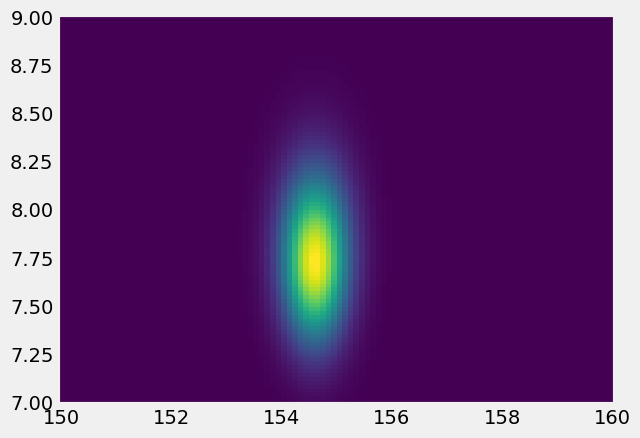

In [11]:
#@title 4.18
plt.pcolormesh(mu, sigma,LL_prob)
plt.show()

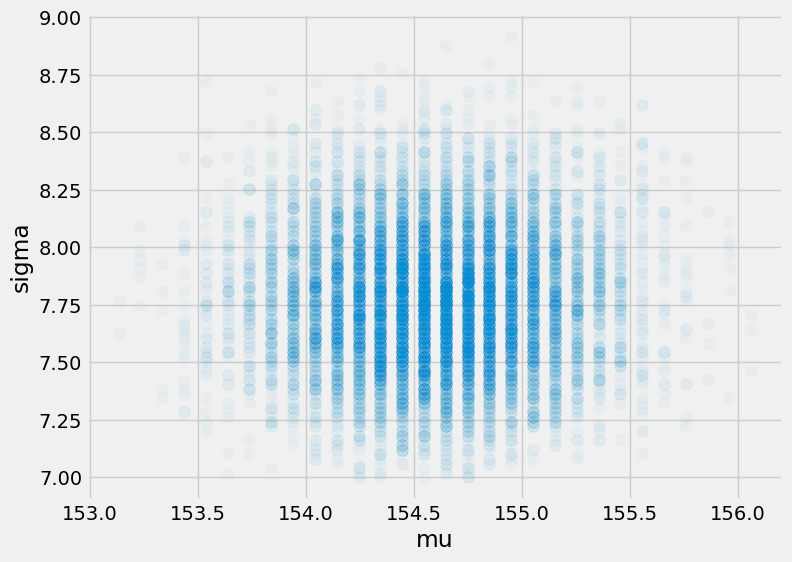

In [12]:
#@title 4.19 - 4.20
df = pd.DataFrame({'mu':mu.reshape(-1,),
                   'sigma':sigma.reshape(-1,),
                   'prob':LL_prob.reshape(-1,)})
df_samples= df.sample(n=10000,replace = True,axis =0,weights = 'prob',random_state=1)
fig,axs = plt.subplots(1,1,figsize = (8,6))
axs.scatter(df_samples.mu, df_samples.sigma, s=70, alpha=0.03)
axs.set_xlabel('mu')
axs.set_ylabel('sigma')
fig.show()

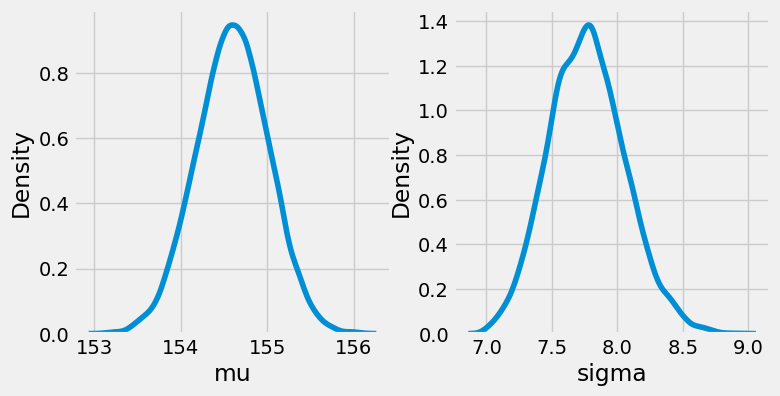

In [13]:
#@title 4.21
fig,axs = plt.subplots(1,2,figsize = (8,4))
sns.kdeplot(df_samples.mu,common_norm=True,ax=axs[0])
sns.kdeplot(df_samples.sigma,common_norm=True,ax=axs[1])
fig.show()

In [14]:
#@title 4.22
print(arviz.hdi(df_samples.mu.to_numpy(),hdi_prob = 0.89))
print(arviz.hdi(df_samples.sigma.to_numpy(),hdi_prob = 0.89))

[154.0404  155.35353]
[7.3030305 8.212121 ]


In [15]:
#@title Scratch Code
## defining the model in crude way and implementing
def joint_log_prob_model(mu_sigma):
  mu_dist = tfp_jax.distributions.Normal(loc=178., scale=20)
  sigma_dist = tfp_jax.distributions.Uniform(low=0., high=50.)
  height_dist = tfp_jax.distributions.Normal(loc=mu_sigma[0], scale=mu_sigma[1])

  return -1*(
      mu_dist.log_prob(mu_sigma[0]) +
      sigma_dist.log_prob(mu_sigma[1]) +
      height_dist.log_prob(height_arr).sum()
  )
## using tfp optimizer we explicitly pass the value_and_gradient function
testfn=lambda x: tfp_jax.math.value_and_gradient(joint_log_prob_model,x)
test = tfp_jax.optimizer.bfgs_minimize(value_and_gradients_function= testfn,initial_position=jnp.array([height_arr.mean(),height_arr.std()]))
print(test)
## using scipy optimizer we do not need to pass the gradient fn
test_fn = ScipyMinimize(fun= joint_log_prob_model,method = 'BFGS' )
results = test_fn.run(init_params =jnp.array([height_arr.mean(),height_arr.std()] ))
print(results)

BfgsOptimizerResults(converged=Array(True, dtype=bool), failed=Array(False, dtype=bool), num_iterations=Array(4, dtype=int32), num_objective_evaluations=Array(9, dtype=int32), position=Array([154.60703 ,   7.731335], dtype=float32), objective_value=Array(1227.916, dtype=float32), objective_gradient=Array([4.7780573e-05, 1.5258789e-05], dtype=float32), inverse_hessian_estimate=Array([[ 0.16988619, -0.3514963 ],
       [-0.3514963 ,  0.8105828 ]], dtype=float32))
OptStep(params=Array([154.60701  ,   7.7314134], dtype=float32), state=ScipyMinimizeInfo(fun_val=Array(1227.916, dtype=float32, weak_type=True), success=False, status=2, iter_num=2, hess_inv=Array([[ 0.33964095, -0.34856337],
       [-0.34856337,  0.83966327]], dtype=float32), num_fun_eval=Array(53, dtype=int32), num_jac_eval=Array(41, dtype=int32), num_hess_eval=Array(0, dtype=int32)))


In [16]:
#@title 4.26
d = pd.read_csv('https://raw.githubusercontent.com/sushmit86/Statiistical_rethinking_jax/main/Howell1.csv',sep= ';')
d2 = d[d.age >= 18].copy()
## should have 352 rows
print(d2.shape)
height_arr = d2.height.values
weight_arr = d2.weight.values

(352, 4)


In [17]:
mu.shape

(100, 100)

In [18]:
#@title 4.27
# using JointDistributionNamedAutoBatched to define model
num_rows = 352
model = tfp_jax.distributions.JointDistributionNamedAutoBatched({
  'mu': tfp_jax.distributions.Normal(loc=178., scale=20., name='mu'),
  'sigma': tfp_jax.distributions.Uniform(low=0., high=50., name='sigma'),
  'height': lambda mu, sigma: tfp_jax.distributions.Sample(tfp_jax.distributions.Normal(loc=mu, scale=sigma), sample_shape=[num_rows]),
})

# model = tfp_jax.distributions.JointDistributionNamedAutoBatched(dict(
#   mu =  tfp_jax.distributions.Normal(loc=178., scale=20.),
#   sigma= tfp_jax.distributions.Uniform(low=0., high=50.),
#   height = lambda mu,sigma: tfp_jax.distributions.Normal(loc=mu, scale=sigma),
# ))


In [19]:
#@title 4.28 - 4.30
credib_interval = 0.89
nll = lambda parameters: -1*model.log_prob({'height':height_arr, 'mu' : parameters[0], 'sigma' :parameters[1]})
optimize_fn = ScipyMinimize(fun= nll,method = 'L-BFGS-B' )
mu_start = height_arr.mean()
std_start = height_arr.std()
results = optimize_fn.run(init_params = jnp.array([mu_start,std_start]))
print(results)
inv_hessian_matrix = jnp.linalg.inv(jax.hessian(nll)(results.params))
print(inv_hessian_matrix)
std_dev = jnp.diagonal(inv_hessian_matrix)**(1/2)
mu_posterior = tfp_jax.distributions.Normal(loc=results.params[0],scale=std_dev[0])
low_credib_interval = (1 - credib_interval)/2
high_credib_interval = 1 - low_credib_interval
print(mu_posterior.quantile(low_credib_interval),mu_posterior.quantile(high_credib_interval))

sigma_posterior = tfp_jax.distributions.Normal(loc=results.params[1],scale=std_dev[1])
print(sigma_posterior.quantile(low_credib_interval),sigma_posterior.quantile(high_credib_interval))

OptStep(params=Array([154.60701 ,   7.731336], dtype=float32), state=ScipyMinimizeInfo(fun_val=Array(1227.916, dtype=float32, weak_type=True), success=True, status=0, iter_num=3, hess_inv=LbfgsInvHessProduct(sk=[[ 9.92629319e-03  6.47545289e-07]
 [-6.07653524e-06  9.41097399e-06]], yk=[[ 5.85252351e-02 -7.24792480e-05]
 [-8.96587953e-05  1.10626221e-04]]), num_fun_eval=Array(24, dtype=int32), num_jac_eval=Array(24, dtype=int32), num_hess_eval=Array(0, dtype=int32)))
[[0.16973974 0.0002177 ]
 [0.0002176  0.08490601]]
153.94856 155.26546
7.2656446 8.197028


In [20]:
#@title 4.31
# using JointDistributionNamedAutoBatched to define model
num_rows = 352
model = tfp_jax.distributions.JointDistributionNamedAutoBatched({
  'mu': tfp_jax.distributions.Normal(loc=178., scale=0.1, name='mu'),
  'sigma': tfp_jax.distributions.Uniform(low=0., high=50., name='sigma'),
  'height': lambda mu, sigma: tfp_jax.distributions.Sample(tfp_jax.distributions.Normal(loc=mu, scale=sigma), sample_shape=[num_rows]),
})

credib_interval = 0.89
nll = lambda parameters: -1*model.log_prob({'height':height_arr, 'mu' : parameters[0], 'sigma' :parameters[1]})
optimize_fn = ScipyMinimize(fun= nll,method = 'L-BFGS-B' )
mu_start = height_arr.mean()
std_start = height_arr.std()
results = optimize_fn.run(init_params = jnp.array([mu_start,std_start]))
print(results.params)
inv_hessian_matrix = jnp.linalg.inv(jax.hessian(nll)(results.params))
print(inv_hessian_matrix)
std_dev = jnp.diagonal(inv_hessian_matrix)**(1/2)
mu_posterior = tfp_jax.distributions.Normal(loc=results.params[0],scale=std_dev[0])
low_credib_interval = (1 - credib_interval)/2
high_credib_interval = 1 - low_credib_interval
print(mu_posterior.quantile(low_credib_interval),mu_posterior.quantile(high_credib_interval))
sigma_posterior = tfp_jax.distributions.Normal(loc=results.params[1],scale=std_dev[1])
print(sigma_posterior.quantile(low_credib_interval),sigma_posterior.quantile(high_credib_interval))

[177.86327  24.51747]
[[0.01004713 0.00953479]
 [0.00953478 0.8629309 ]]
177.70306 178.02347
23.032843 26.002096


In [21]:
#@title 4.32 - 4.36
# using JointDistributionNamedAutoBatched to define model
num_rows = 352
model = tfp_jax.distributions.JointDistributionNamedAutoBatched({
  'mu': tfp_jax.distributions.Normal(loc=178., scale=20., name='mu'),
  'sigma': tfp_jax.distributions.Uniform(low=0., high=50., name='sigma'),
  'height': lambda mu, sigma: tfp_jax.distributions.Sample(tfp_jax.distributions.Normal(loc=mu, scale=sigma), sample_shape=[num_rows]),
})
credib_interval = 0.89
nll = lambda parameters: -1*model.log_prob({'height':height_arr, 'mu' : parameters[0], 'sigma' :parameters[1]})
optimize_fn = ScipyMinimize(fun= nll,method = 'L-BFGS-B' )
mu_start = height_arr.mean()
std_start = height_arr.std()
results = optimize_fn.run(init_params = jnp.array([mu_start,std_start]))
inv_hessian_matrix = jnp.linalg.inv(jax.hessian(nll)(results.params))
post_dist = tfp_jax.distributions.MultivariateNormalFullCovariance(
    loc=results.params,covariance_matrix=inv_hessian_matrix )
post_samples = post_dist.sample( sample_shape=10000,seed=key)
display(pd.DataFrame(post_samples,columns=['mu','sigma']).describe())
print(arviz.hdi(np.array(post_samples[:,0]),hdi_prob = 0.89))
print(arviz.hdi(np.array(post_samples[:,1]),hdi_prob = 0.89))

,mu,sigma
count,10000.000,10000.000
mean,154.608,7.735
std,0.416,0.289
min,152.922,6.634
25%,154.325,7.538
50%,154.610,7.737
75%,154.893,7.933
max,156.340,8.797


[153.91577 155.23604]
[7.250741 8.170146]


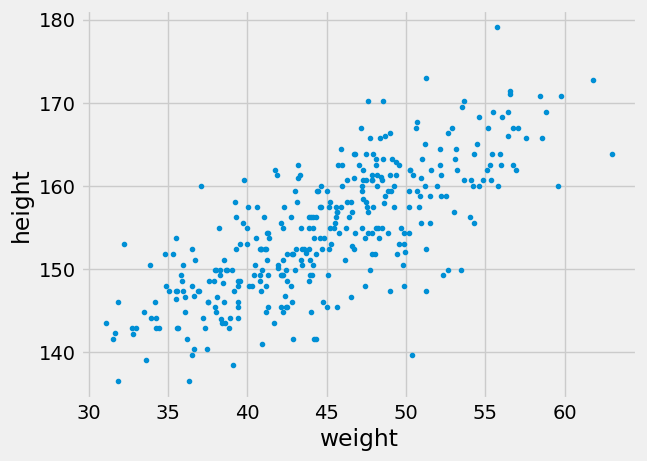

In [22]:
#@title 4.37
plt.plot(d2.weight,d2.height,'.')
plt.xlabel('weight')
plt.ylabel('height')
plt.show()

In [23]:
#@title 4.38
model = tfp_jax.distributions.JointDistributionNamedAutoBatched(dict(
  alpha= tfp_jax.distributions.Normal(loc=178., scale=20.),
  beta= tfp_jax.distributions.Normal(loc=0., scale=10.),
  sigma= tfp_jax.distributions.Uniform(low=0., high=50.),
  mu = lambda alpha,beta: tfp_jax.distributions.Deterministic(alpha + beta * (weight_arr - weight_arr.mean())),
  height =  lambda mu,sigma: tfp_jax.distributions.Sample(tfp_jax.distributions.Normal(
      loc= mu, scale=sigma))
))

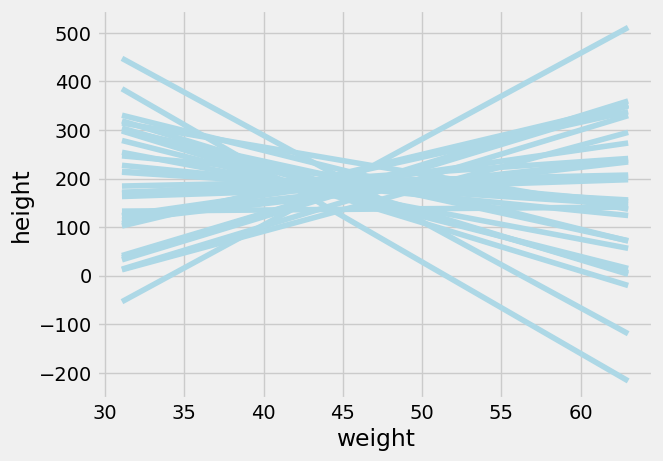

In [24]:
#@title 4.39
min_weight = weight_arr.min()
max_weight = weight_arr.max()
samples = model.sample(seed=key,sample_shape = 30)
weight_to_plot_arr = jnp.linspace(min_weight,max_weight,100)
# weight_to_plot_arr = weight_to_plot_arr - weight_arr.mean()
for _alpha,_beta in zip(samples['alpha'],samples['beta']):
  plt.plot(weight_to_plot_arr, _alpha + (weight_to_plot_arr - weight_arr.mean()) * _beta,color = 'lightblue')
plt.xlabel('weight')
plt.ylabel('height')
plt.show()

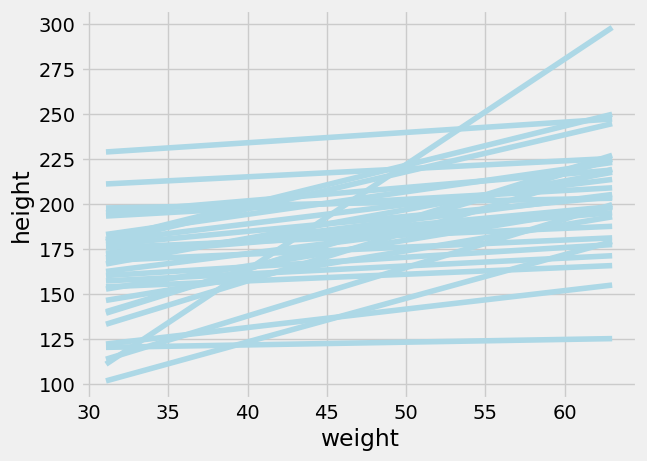

In [25]:
#@title 4.40 - 4.41
model = tfp_jax.distributions.JointDistributionNamedAutoBatched(dict(
  alpha= tfp_jax.distributions.Normal(loc=178., scale=20.),
  log_beta= tfp_jax.distributions.LogNormal(loc=0., scale=1.),
  sigma= tfp_jax.distributions.Uniform(low=0., high=50.),
  mu = lambda alpha,log_beta: tfp_jax.distributions.Deterministic(alpha + log_beta * (weight_arr - weight_arr.mean())),
  height =  lambda mu,sigma: tfp_jax.distributions.Sample(tfp_jax.distributions.Normal(
      loc= mu, scale=sigma))
))

min_weight = weight_arr.min()
max_weight = weight_arr.max()
samples = model.sample(seed=key,sample_shape = 30)
weight_to_plot_arr = np.linspace(min_weight,max_weight,100)
# weight_to_plot_arr = weight_to_plot_arr - weight_arr.mean()
for _alpha,_log_beta in zip(samples['alpha'],samples['log_beta']):
  plt.plot(weight_to_plot_arr, _alpha + (weight_to_plot_arr - weight_arr.mean()) * _log_beta,color = 'lightblue')
plt.xlabel('weight')
plt.ylabel('height')
plt.show()

In [26]:
#@title 4.42 - 4.45

d = pd.read_csv('https://raw.githubusercontent.com/sushmit86/Statiistical_rethinking_jax/main/Howell1.csv',sep= ';')
d2 = d[d.age >= 18].copy()
## should have 352 rows
print(d2.shape)
height_arr = d2.height.values
weight_arr = d2.weight.values

model = tfp_jax.distributions.JointDistributionNamedAutoBatched(OrderedDict(
  alpha= tfp_jax.distributions.Normal(loc=178., scale=20.),
  log_beta= tfp_jax.distributions.LogNormal(loc=0., scale=1.),
  sigma= tfp_jax.distributions.Uniform(low=0., high=50.),
  mu = lambda alpha,log_beta,sigma: tfp_jax.distributions.Deterministic(alpha + log_beta * (jnp.array(weight_arr) - jnp.array(weight_arr).mean())),
  height =  lambda mu,sigma: tfp_jax.distributions.Sample(tfp_jax.distributions.Normal(
      loc= mu, scale=sigma))
))

credib_interval = 0.89
# if we need to use nll
# nll = lambda parameters: -1*model.log_prob({'height':height_arr, 'alpha' : parameters[0],
#                                             'log_beta' :parameters[1],
#                                             'sigma': parameters[2]})

# nll = lambda parameters: -model.experimental_sample_and_log_prob(
#       height=height_arr,
#       alpha=parameters[0],
#       log_beta=parameters[1],
#       sigma=parameters[2],
#       seed=jax.random.PRNGKey(0),
#   )[1]

def nll(parameters):
  samples = model.sample( height=height_arr,
      alpha=parameters[0],
      log_beta=parameters[1],
      sigma=parameters[2],
      seed=jax.random.PRNGKey(0))
  return -1 * model.log_prob(samples)

optimize_fn = ScipyMinimize(fun= nll,method = 'L-BFGS-B' )

alpha_start = height_arr.mean()
log_beta_start = (height_arr.max() - height_arr.min())/(weight_arr.max() - weight_arr.min())
std_start = height_arr.std()
results = optimize_fn.run(init_params = jnp.array([alpha_start,log_beta_start,std_start]))
df_result,cov_matrix,df_post_samples = marginal_test_results(model,results,nll)
np.set_printoptions(precision=4)
pd.set_option("display.precision", 3)
display(df_result.round(3))
print(np.round(cov_matrix,3))

(352, 4)


,mean,sd,low,high
alpha,154.603,0.270,154.171,155.035
log_beta,0.903,0.042,0.836,0.970
sigma,5.072,0.191,4.766,5.377


[[ 0.073 -0.     0.   ]
 [-0.     0.002 -0.   ]
 [ 0.    -0.     0.037]]


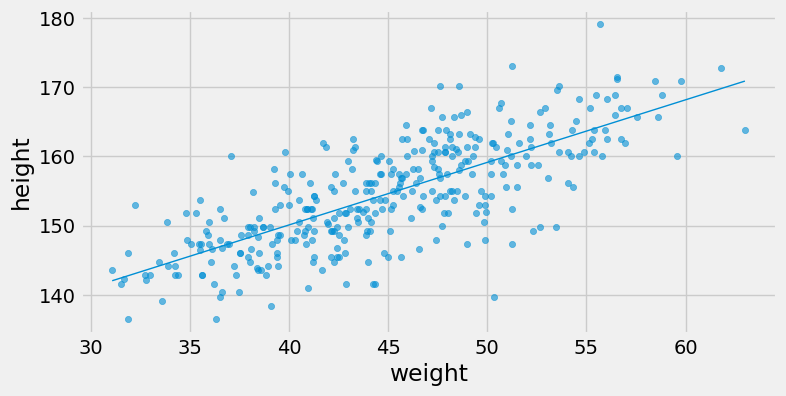

In [27]:
#@title 4.46
# weight_x_arr = np.linspace(weight_arr.min(),weight_arr.max(),100)
weight_x_arr = np.linspace(weight_arr.min(),weight_arr.max(),100)
mean_mu_pred = df_post_samples.alpha.mean() + df_post_samples.log_beta.mean() * (weight_x_arr - weight_arr.mean())
fig, axs = plt.subplots(1, 1, figsize=(8, 4))
axs.scatter(d2.weight, d2.height,alpha=0.6,s=20)
axs.plot(weight_x_arr, mean_mu_pred,linewidth=1.0)
axs.set_xlabel('weight')
axs.set_ylabel('height')
fig.show()

In [28]:
#@title 4.47
df_post_samples.head(n=5)

,alpha,log_beta,sigma
0,154.645,0.847,5.015
1,154.610,0.919,5.202
2,154.472,0.871,4.935
3,154.782,0.889,4.950
4,154.485,0.863,4.806


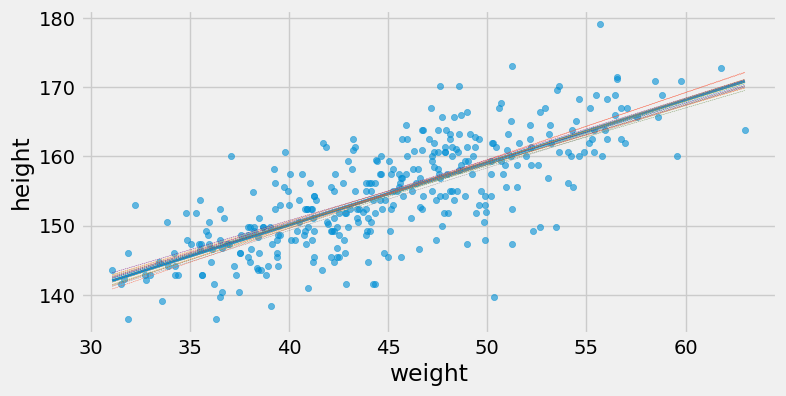

In [29]:
#@title 4.48 - 4.49 [ full data ]
weight_x_arr = np.linspace(weight_arr.min(),weight_arr.max(),100)

mean_mu_pred = df_result.loc['alpha','mean'] + df_result.loc['log_beta','mean'] * (weight_x_arr - weight_arr.mean())
fig, axs = plt.subplots(1, 1, figsize=(8, 4))
axs.scatter(d2.weight, d2.height,alpha=0.6,s=20)
axs.plot(weight_x_arr, mean_mu_pred,linewidth=2.0)
for index, row in df_post_samples[:20].iterrows():
    _mean_mu_pred = row['alpha'] + row['log_beta'] * (weight_x_arr - weight_arr.mean())
    axs.plot(weight_x_arr, _mean_mu_pred,linewidth=0.3,linestyle = '--')
axs.set_xlabel('weight')
axs.set_ylabel('height')
fig.show()
axs.set_xlabel('weight')
axs.set_ylabel('height')
fig.show()
# cloud of regression clusters as number of points increases

[158.5852 159.6738]


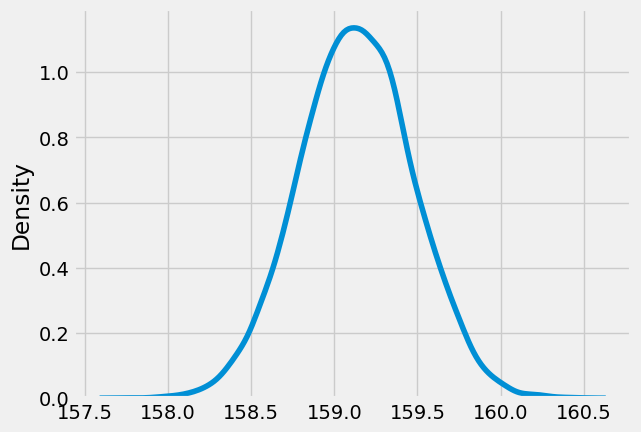

In [30]:
#@title 4.50 - 4.52
weight_example = 50
mu_at_50 = df_post_samples.alpha + df_post_samples.log_beta * (weight_example - weight_arr.mean())
mu_at_50
print(arviz.hdi(mu_at_50.to_numpy(),hdi_prob = 0.89))
sns.kdeplot(mu_at_50)
plt.show()

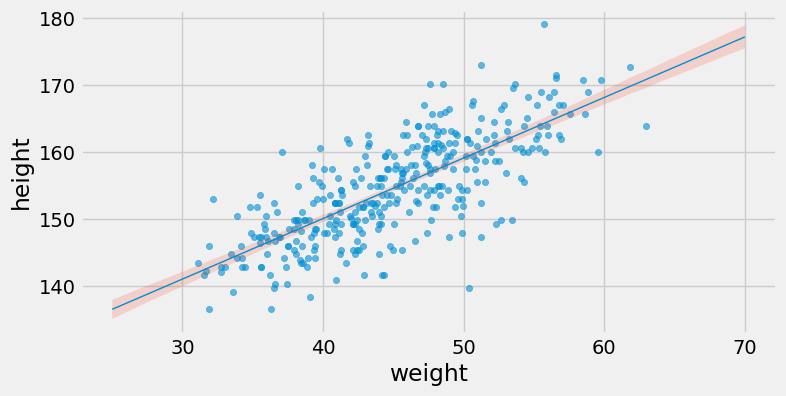

In [31]:
# 89% interval for each weight
# we can get the mean
#@title 4.53 - 4.57
weight_x_arr = np.arange(25,71)
get_mu_lower = lambda _weight: arviz.hdi(np.array(df_post_samples.alpha +
                                            df_post_samples.log_beta * (_weight - weight_arr.mean())),hdi_prob = credib_interval)[0]

get_mu_upper = lambda _weight: arviz.hdi(np.array(df_post_samples.alpha +
                                            df_post_samples.log_beta * (_weight - weight_arr.mean())),hdi_prob = credib_interval)[1]
vfunc_lower = np.vectorize(get_mu_lower)
vfunc_upper = np.vectorize(get_mu_upper)
mu_lower=vfunc_lower(weight_x_arr)
mu_upper=vfunc_upper(weight_x_arr)

weight_x_arr = np.arange(25,71)
mean_mu_pred = df_result.loc['alpha','mean'] + df_result.loc['log_beta','mean'] * (weight_x_arr - weight_arr.mean())
fig, axs = plt.subplots(1, 1, figsize=(8, 4))
axs.scatter(d2.weight, d2.height,alpha=0.6,s=20)
axs.plot(weight_x_arr, mean_mu_pred,linewidth=1.0)

axs.fill_between(weight_x_arr, mu_lower,mu_upper, alpha=0.2)
axs.set_xlabel('weight')
axs.set_ylabel('height')
fig.show()

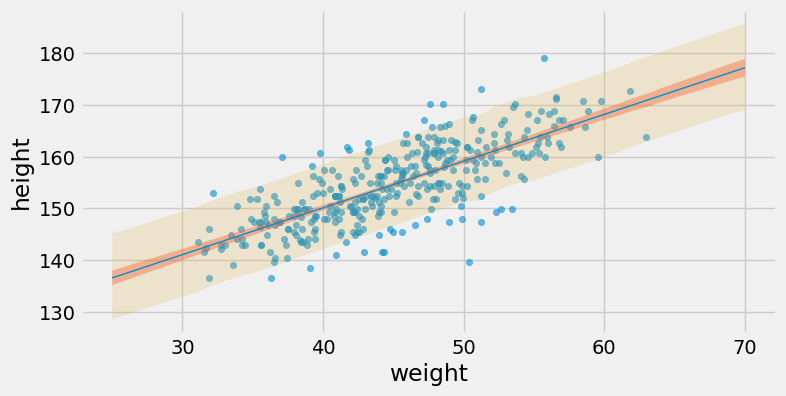

In [32]:
#@title 4.58 - 4.62
post_samples_array = df_post_samples.to_numpy()
fn_mu = lambda _samples, _weight: _samples[:,0] + _samples[:,1] * (_weight - weight_arr.mean())
sampled_mu = jax.vmap(fn_mu,in_axes=(None,0),out_axes=1)(post_samples_array,weight_x_arr)
height_sample_fn = lambda _mu_samples,_sigma : tfp_jax.distributions.Normal(_mu_samples,_sigma).sample(seed=key)
height_samples = jax.vmap(height_sample_fn, in_axes=(1,None),out_axes=1)(sampled_mu,post_samples_array[:,2])
samples_height_hdi = np.apply_along_axis(arviz.hdi,axis=0,arr=np.array(height_samples),hdi_prob=credib_interval).T

mean_mu_pred = df_result.loc['alpha','mean'] + df_result.loc['log_beta','mean'] * (weight_x_arr - weight_arr.mean())
fig, axs = plt.subplots(1, 1, figsize=(8, 4))
axs.scatter(d2.weight, d2.height,alpha=0.6,s=20)
axs.plot(weight_x_arr, mean_mu_pred,linewidth=1.0)

axs.fill_between(weight_x_arr, mu_lower,mu_upper, alpha=0.4)
axs.fill_between(weight_x_arr, samples_height_hdi[:,0],samples_height_hdi[:,1], alpha=0.2)
axs.set_xlabel('weight')
axs.set_ylabel('height')
fig.show()

In [33]:
df = pd.read_csv('https://raw.githubusercontent.com/sushmit86/Statiistical_rethinking_jax/main/cherry_blossoms.csv',sep= ';')
df.head()

df.describe()

,year,doy,temp,temp_upper,temp_lower
count,1215.000,827.000,1124.000,1124.000,1124.000
mean,1408.000,104.541,6.142,7.185,5.099
std,350.885,6.407,0.664,0.993,0.850
min,801.000,86.000,4.670,5.450,0.750
25%,1104.500,100.000,5.700,6.480,4.610
50%,1408.000,105.000,6.100,7.040,5.145
75%,1711.500,109.000,6.530,7.720,5.543
max,2015.000,124.000,8.300,12.100,7.740


In [34]:
d2 = df[~df.temp.isna()]
temp_array = d2.temp.values
print(temp_array.shape)

(1124,)


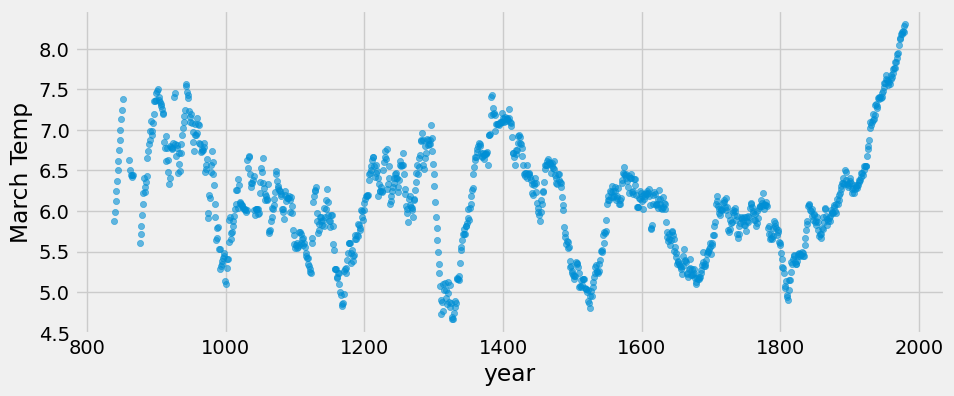

In [35]:
fig, axs = plt.subplots(1, 1, figsize=(10, 4))
axs.scatter(df.year, df.temp,alpha=0.6,s=20)
axs.set_xlabel('year')
axs.set_ylabel('March Temp')
fig.show()

In [36]:
num_knots = 15
knot_list = np.quantile(d2.year, np.linspace(0, 1, num_knots))

In [37]:
from scipy.interpolate import BSpline
knots = np.pad(knot_list, (3, 3), mode="edge")
B = BSpline(knots, np.identity(num_knots + 2), k=3)(d2.year.values)

In [38]:
model_spline = tfp_jax.distributions.JointDistributionNamedAutoBatched(OrderedDict(
  alpha= tfp_jax.distributions.Normal(loc=6., scale=10.),
  sigma= tfp_jax.distributions.Exponential(rate=1.),
  w_j = tfp_jax.distributions.Sample(tfp_jax.distributions.Normal(loc=0., scale=1.), sample_shape= 17),
  mu = lambda alpha,w_j: tfp_jax.distributions.Deterministic(alpha + jnp.matmul(B,w_j)),
  temperature =  lambda mu,sigma: tfp_jax.distributions.Sample(tfp_jax.distributions.Normal(
      loc= mu, scale=sigma))
))

In [39]:
def nll(parameters):
  samples = model_spline.sample( temperature=temp_array,
      alpha=parameters[0],
      sigma=parameters[1],
      w_j = parameters[2:],
      seed=jax.random.PRNGKey(0))
  return -1 * model_spline.log_prob(samples)

optimize_fn = ScipyMinimize(fun= nll,method = 'L-BFGS-B' )
alpha_start = temp_array.mean()
sigma_start = temp_array.std()
w_j_start = jnp.zeros(17)
results = optimize_fn.run(init_params = jnp.concatenate((jnp.append(jnp.array(alpha_start),jnp.array(sigma_start)),
                 w_j_start)))


df_result,cov_matrix,df_post_samples = marginal_test_results(model_spline,results,nll)
np.set_printoptions(precision=4)
pd.set_option("display.precision", 3)
display(df_result.round(3))

,mean,sd,low,high
alpha,6.314,0.243,5.926,6.702
sigma,0.344,0.007,0.333,0.356
w_j_0,0.105,0.268,-0.322,0.533
w_j_1,0.249,0.279,-0.197,0.695
w_j_2,1.208,0.272,0.774,1.642
w_j_3,-0.812,0.259,-1.227,-0.398
w_j_4,0.109,0.257,-0.303,0.520
w_j_5,-1.394,0.257,-1.805,-0.984
w_j_6,1.165,0.257,0.754,1.575
w_j_7,-1.907,0.257,-2.318,-1.497
